In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.6 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=67d490d2bfd8e300b7a340c280033e9162e87567060ef0b16e467061d86a5d6b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=1827bc5c998082d12a99645b4bf77fe8a51c91a642d5d35922ad850659e4dc6e
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [2]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-urpk7_l8
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-urpk7_l8
  Resolved https://github.com/albumentations-team/albumentations to commit 7be7f1b4c9a77df0fee9246a983f33bb908fa611
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for albumentations: filename=albumentations-1.4.16-py3-none-any.whl size=216508 sha256=f4df0ad884ffedfa6b6f5220d96fc41988dc2f77802cf544283b7041c2930742
  Stored in directory: /tmp/pip-ephem-wheel-cache-pf0iw7oa/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.16
    Uninstalling albucore-0.0.16:
      Successfully uninstalled albucore-0.0.16
  Attempting uninstall: al

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

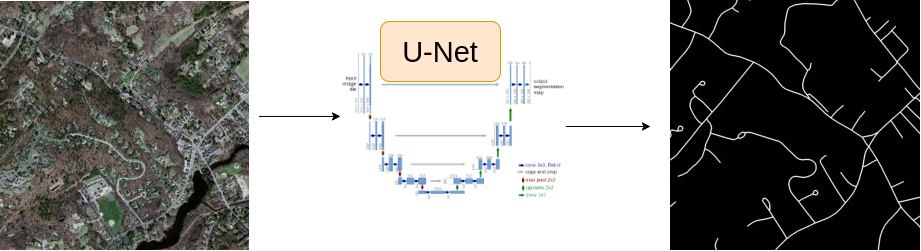

# Download Subset Dataset

In [4]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 44.62 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [5]:
import sys
sys.path.append('/kaggle/input/aerial-image-dataset/Road_seg_dataset-master')

In [6]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [7]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')


# Task : 2 Setup Configurations

In [17]:
CSV_FILE = '/kaggle/input/aerial-image-dataset/Road_seg_dataset-master/train.csv'
DATA_DIR = '/kaggle/input/aerial-image-dataset/'

DEVICE = 'cuda'

EPOCHS = 20
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [9]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [64]:
idx = 3

row = df.iloc[idx]

# # Extract image and mask paths
image_loc = row.images
mask_loc = row.masks

image_full_path = '/kaggle/input/aerial-image-dataset/Road_seg_dataset-master/' + image_loc
mask_full_path = '/kaggle/input/aerial-image-dataset/Road_seg_dataset-master/' + mask_loc

image = cv2.imread(image_full_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE) / 255.0

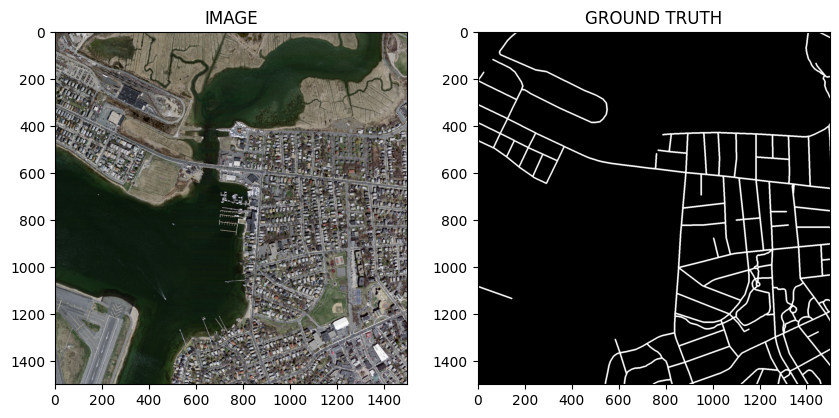

In [65]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [66]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [67]:
import albumentations as A

In [68]:
def get_train_augs():
    return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
    return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [69]:
from torch.utils.data import Dataset

In [88]:
class SegmentationDataset(Dataset):
    
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_loc = row.images
        mask_loc = row.masks

        image_full_path = '/kaggle/input/aerial-image-dataset/Road_seg_dataset-master/' + image_loc
        mask_full_path = '/kaggle/input/aerial-image-dataset/Road_seg_dataset-master/' + mask_loc

        image = cv2.imread(image_full_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image'] #(h,w,c)
            mask =  data['mask']

            image = np.transpose(image, (2, 0, 1)).astype(np.float32) #(c, h, w)
            mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) #(c, h, w

            image = torch.Tensor(image) / 255.0
            mask = torch.round(torch.Tensor(mask) / 255.0)


        return image, mask

In [89]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [90]:
print(f'Length of trainset : {len(trainset)}')
print(f'Length of validset : {len(validset)}')

Length of trainset : 159
Length of validset : 40


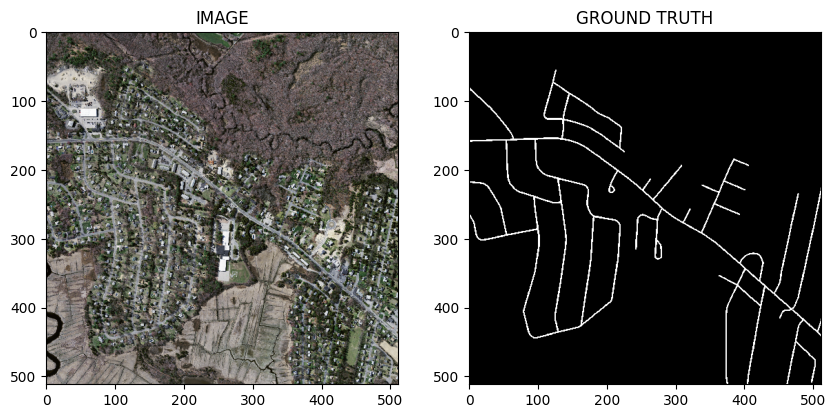

In [91]:
idx = 21

image, mask = trainset[idx]

show_image(image, mask)


# Task 5 : Load dataset into batches

In [92]:
from torch.utils.data import DataLoader

In [93]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [94]:
print(f'Total number of batches in trainloader : {len(trainloader)}')
print(f'Total number of batches in validloader : {len(validloader)}')

Total number of batches in trainloader : 20
Total number of batches in validloader : 5


In [95]:
for images, masks in trainloader:
    print(f"One batch image shape: {images.shape}")
    print(f"One batch mask shape: {masks.shape}")
    break;

One batch image shape: torch.Size([8, 3, 512, 512])
One batch mask shape: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [96]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [97]:
class SegmentationModel(nn.Module):
    
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.backbone = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks =None):
        logits = self.backbone(images)

        if masks != None:
            return logits, DiceLoss(mode= 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

        return logits

In [98]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 132MB/s] 


# Task 7 : Create Train and Validation Function

In [99]:
def train_fn(dataloader, model, optimizer):
    

    model.train()  #Turn ON dropout, batchnorm, etc..

    total_loss = 0.0

    for images, masks in tqdm(trainloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [100]:
def eval_fn(dataloader, model):
    
    model.eval()  #Turn OFF dropout, batchnorm, etc..

    total_loss = 0.0

    with torch.no_grad():
        

        for images, masks in tqdm(trainloader):
 
              images = images.to(DEVICE)
              masks = masks.to(DEVICE)
              logits, loss = model(images, masks)
              total_loss += loss.item()

        return total_loss / len(dataloader)

# Task 8 : Train Model

In [101]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [102]:
best_loss = np.inf

for i in range(EPOCHS):
    
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_loss:
        
        torch.save(model.state_dict(), 'best-model.pt')
        print("SAVED-MODEL")
        best_loss = valid_loss

    print(f"EPOCH : {i+1}")
    print(f"Train Loss : {train_loss:.4f}")
    print(f"Valid Loss : {valid_loss:.4f}")

100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


SAVED-MODEL
EPOCH : 1
Train Loss : 1.1628
Valid Loss : 4.7614


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


SAVED-MODEL
EPOCH : 2
Train Loss : 0.8341
Valid Loss : 3.1006


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


SAVED-MODEL
EPOCH : 3
Train Loss : 0.7405
Valid Loss : 2.8855


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


SAVED-MODEL
EPOCH : 4
Train Loss : 0.6973
Valid Loss : 2.7182


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


SAVED-MODEL
EPOCH : 5
Train Loss : 0.6626
Valid Loss : 2.5581


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


EPOCH : 6
Train Loss : 0.6597
Valid Loss : 2.5622


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


SAVED-MODEL
EPOCH : 7
Train Loss : 0.6523
Valid Loss : 2.5320


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


SAVED-MODEL
EPOCH : 8
Train Loss : 0.6387
Valid Loss : 2.4545


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


EPOCH : 9
Train Loss : 0.6267
Valid Loss : 2.5401


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


SAVED-MODEL
EPOCH : 10
Train Loss : 0.6245
Valid Loss : 2.4217


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


SAVED-MODEL
EPOCH : 11
Train Loss : 0.6130
Valid Loss : 2.3949


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


EPOCH : 12
Train Loss : 0.6139
Valid Loss : 2.4248


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


SAVED-MODEL
EPOCH : 13
Train Loss : 0.6107
Valid Loss : 2.3732


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


EPOCH : 14
Train Loss : 0.6080
Valid Loss : 2.3834


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]

SAVED-MODEL
EPOCH : 15
Train Loss : 0.5915
Valid Loss : 2.3186


# Task 9 : Inference

In [121]:
idx = 9

model.load_state_dict(torch.load('/kaggle/working/best-model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) --> (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

/tmp/ipykernel_30/1269454981.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best-model.pt'))


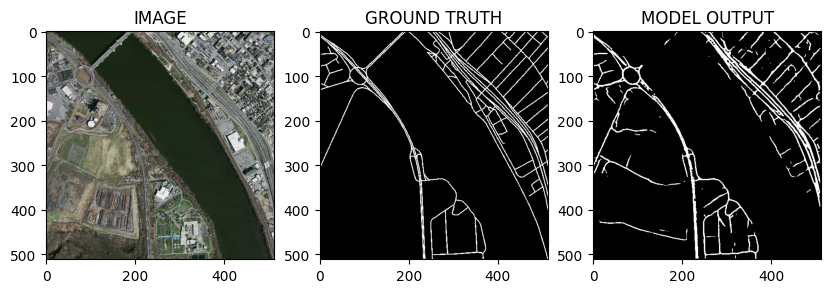

In [122]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))